In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kaggle.api.kaggle_api_extended import KaggleApi
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
!chcp 65001
path = %pwd

Active code page: 65001


In [4]:
api.dataset_download_files("uciml/human-activity-recognition-with-smartphones", path = path, unzip = True)

Dataset URL: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones


In [5]:
os.listdir()

['.ipynb_checkpoints', '2 лаба.ipynb', 'test.csv', 'train.csv']

In [278]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [279]:
columns = [col for col in df_train.columns if ('Acc' in col or 'Gyro' in col)]
window_size = 7  
df_train[columns] = df_train[columns].rolling(window=window_size, min_periods=1).mean()
df_test[columns] = df_test[columns].rolling(window=window_size, min_periods=1).mean()

In [280]:
def add_gaussian_noise(df):
    df_copy = df.copy()
    noise_lvl = 0.1
    for column in df_copy.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_lvl, df_copy[column].shape)
        df_copy[column] = df_copy[column] + noise
    mask = np.random.rand(*df_copy.shape) <= 0.1
    df_copy[mask] = np.nan
    return df_copy

In [281]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((sequence, target))
    return sequences

In [282]:
df_train = df_train.select_dtypes(include=[np.number])  

In [283]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)
df_train_noise = add_gaussian_noise(df_train)
df_val_noise = add_gaussian_noise(df_val)

In [284]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_val_scaled = pd.DataFrame(scaler.transform(df_val), columns=df_val.columns)
df_train_noise_scaled = pd.DataFrame(scaler.transform(df_train_noise.fillna(0)), columns=df_train_noise.columns)
df_val_noise_scaled = pd.DataFrame(scaler.transform(df_val_noise.fillna(0)), columns=df_val_noise.columns)

train_sequences = create_sequences(df_train_noise_scaled.values, window_size)
val_sequences = create_sequences(df_val_noise_scaled.values, window_size)

X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_val = np.array([seq[0] for seq in val_sequences])
y_val = np.array([seq[1] for seq in val_sequences])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_train = X_train.view(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.view(X_val.shape[0], X_val.shape[1], X_val.shape[2])
y_train = y_train.view(y_train.shape[0], 1, y_train.shape[1])
y_val = y_val.view(y_val.shape[0], 1, y_val.shape[1])

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [285]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [286]:
input_size = X_train.shape[2]  
hidden_size = 32  
output_size = y_train.shape[2]
num_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [287]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

In [288]:
epochs = 30
loss_history = []
metrics_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train)

    y_train_squeezed = y_train.squeeze(dim=1)
    y_pred_squeezed = y_pred.squeeze(dim=1)

    loss = criterion(y_pred_squeezed, y_train_squeezed)
    loss_history.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred_np = y_pred_squeezed.cpu().numpy()
        y_train_np = y_train_squeezed.cpu().numpy()

    mse = mean_squared_error(y_train_np, y_pred_np)
    mae = mean_absolute_error(y_train_np, y_pred_np)
    r2 = r2_score(y_train_np, y_pred_np)
    metrics_history.append((mse, mae, r2))

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, MSE: {mse:.6f}, MAE: {mae:.6f}, R2: {r2:.6f}")

Epoch 1/30, Loss: 0.583827, MSE: 0.583827, MAE: 0.640232, R2: -1.268402
Epoch 11/30, Loss: 0.320621, MSE: 0.320621, MAE: 0.438080, R2: -0.167820
Epoch 21/30, Loss: 0.287996, MSE: 0.287996, MAE: 0.397086, R2: -0.042452


In [307]:
metrics_history[-1]

(0.2835243344306946, 0.39987751841545105, -0.021331479772925377)

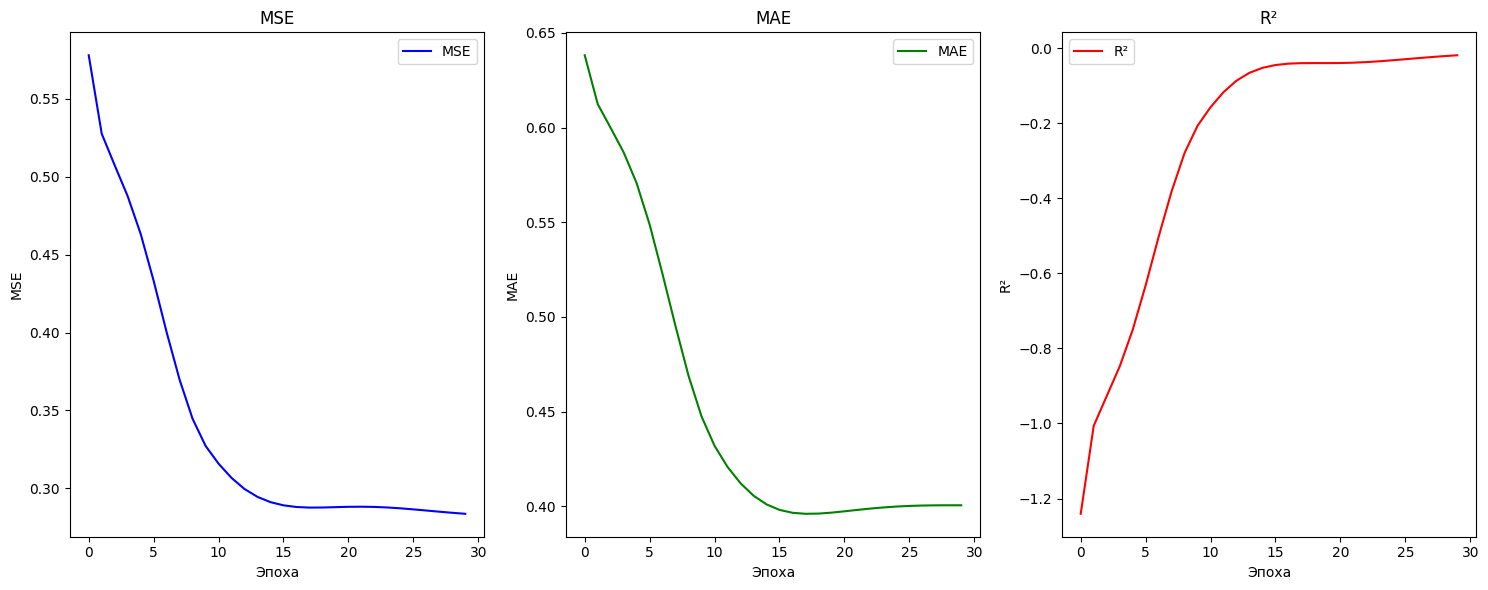

In [290]:
plt.figure(figsize=(15, 6)) 

plt.subplot(1, 3, 1)
plt.plot(mse_history, label="MSE", color='b')
plt.title('MSE')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()

# График для MAE
plt.subplot(1, 3, 2)
plt.plot(mae_history, label="MAE", color='g')
plt.title('MAE')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()

# График для R²
plt.subplot(1, 3, 3)
plt.plot(r2_history, label="R²", color='r')
plt.title('R²')
plt.xlabel('Эпоха')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()

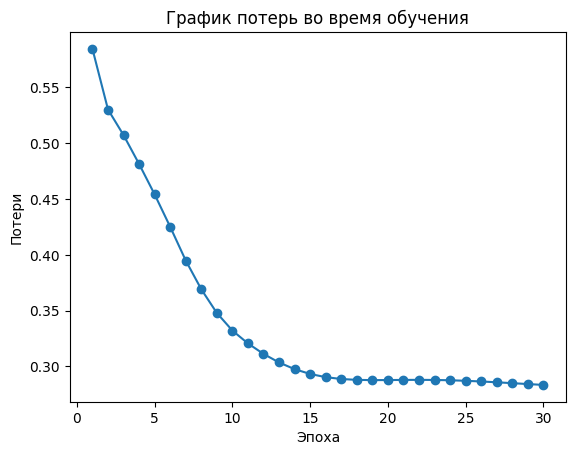

In [291]:
# Построение графика потерь
plt.plot(range(1, epochs+1), loss_history, marker='o', linestyle='-')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('График потерь во время обучения')
plt.show()

In [292]:
# model.eval()
# with torch.no_grad():
#     y_val_pred = model(X_val)

# y_val_pred = y_val_pred.cpu().numpy()
# y_val = y_val.cpu().numpy()

# y_val_pred = scaler.inverse_transform(y_val_pred.reshape(-1, output_size))
# y_val = scaler.inverse_transform(y_val.reshape(-1, output_size))

# print("MSE:", mean_squared_error(y_val, y_val_pred))
# print("MAE:", mean_absolute_error(y_val, y_val_pred))
# print("R²:", r2_score(y_val, y_val_pred))

In [306]:
X_test_missing = df_val_scaled.values 

X_test_linear = pd.DataFrame(X_test_missing).interpolate(method='linear', limit_direction='both').values

X_test_spline = pd.DataFrame(X_test_missing).interpolate(method='spline', order=3, limit_direction='both').values

X_test_tensor = torch.tensor(X_test_missing, dtype=torch.float32).view(1, -1, X_test_missing.shape[1]).to(device)
y_lstm_scaled = model(X_test_tensor).detach().cpu().numpy()

min_len = min(len(y_val), len(X_test_linear), len(X_test_spline), len(y_lstm_scaled))

y_val = y_val[:min_len]
X_test_linear = X_test_linear[:min_len]
X_test_spline = X_test_spline[:min_len]
y_lstm_scaled = y_lstm_scaled[:min_len]

y_pred_np = y_pred.cpu().detach().numpy()  
y_train_np = y_train.cpu().detach().numpy()

X_test_linear = X_test_linear.reshape(-1)
X_test_spline = X_test_spline.reshape(-1)
X_test_tensor = X_test_tensor.reshape(-1)

def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    return mse, mae, r2

y_val_np = y_val.cpu().detach().numpy().squeeze()  
X_test_linear = pd.DataFrame(X_test_linear).interpolate(method='linear', limit_direction='both').values
mse_linear, mae_linear, r2_linear = evaluate(y_val_np, X_test_linear)
print(f"Линейная интерполяция - MSE: {mse_linear}, MAE: {mae_linear}, R²: {r2_linear}")

X_test_spline = pd.DataFrame(X_test_spline).interpolate(method='spline', order=3, limit_direction='both').values
mse_spline, mae_spline, r2_spline = evaluate(y_val_np, X_test_spline)
print(f"Сплайны - MSE: {mse_spline}, MAE: {mae_spline}, R²: {r2_spline}")

y_lstm_scaled = y_lstm_scaled.squeeze()
mse_lstm, mae_lstm, r2_lstm = evaluate(y_val_np, y_lstm_scaled)
print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}, R²: {r2_lstm}")

Линейная интерполяция - MSE: 0.20154067749151064, MAE: 0.30351738859164284, R²: 0.24825091782920994
сплайны - MSE: 0.20154067749151064, MAE: 0.30351738859164284, R²: 0.24825091782920994
LSTM - MSE: 0.2542460262775421, MAE: 0.3666912913322449, R²: 0.05165940523147583


In [300]:
df_interpolated_linear = X_val.interpolate(method='linear')

AttributeError: 'Tensor' object has no attribute 'interpolate'